## Deep Video Priors for Snapshot Compressive Imaging
 
[Yang Liu](https://liuyang12.github.io "Yang Liu, MIT CSAIL"), [MIT CSAIL](https://www.csail.mit.edu/), yliu@csail.mit.edu, updated Dec 9, 2019.

In [1]:
import os
import time
import math
import h5py
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline
%load_ext autoreload
%autoreload 2

from dvp_linear_inv import (gap_denoise_bayer, 
                            gap_denoise, admm_denoise,
                            GAP_TV_rec, ADMM_TV_rec)

from utils import (A_, At_, psnr)

In [2]:
# [0] environment configuration
datasetdir = './dataset/cacti' # dataset
resultsdir = './results' # results

# datname = 'kobe' # name of the dataset
# datname = 'traffic' # name of the dataset
# datname = 'bus_bayer' # name of the dataset
datname = 'messi_bayer' # name of the dataset
# datname = 'messi_c24_bayer' # name of the dataset
# datname = 'hummingbird_c40_bayer' # name of the dataset
# datname = 'football_cif_bayer' # name of the dataset
# datname = 'test' # name of the dataset
# varname = 'X' # name of the variable in the .mat data file

matfile = datasetdir + '/' + datname + '.mat' # path of the .mat data file

In [3]:
# [1] load data
with h5py.File(matfile, 'r') as file: # for '-v7.3' .mat file (MATLAB)
    # print(list(file.keys()))
    meas_bayer = np.array(file['meas_bayer'])
    mask_bayer = np.array(file['mask_bayer'])
    orig_bayer = np.array(file['orig_bayer'])
#==============================================================================
# file = scipy.io.loadmat(matfile) # for '-v7.2' and below .mat file (MATLAB)
# X = list(file[varname])
#==============================================================================

mask_bayer = np.float32(mask_bayer).transpose((2,1,0))
if len(meas_bayer.shape) < 3:
    meas_bayer = np.float32(meas_bayer).transpose((1,0))
else:
    meas_bayer = np.float32(meas_bayer).transpose((2,1,0))
orig_bayer = np.float32(orig_bayer).transpose((2,1,0))
# print(mask_bayer.shape, meas_bayer.shape, orig_bayer.shape)

iframe = 0
MAXB = 255.
(nrows, ncols, nmask) = mask_bayer.shape
if len(meas_bayer.shape) >= 3:
    meas_bayer = np.squeeze(meas_bayer[:,:,iframe])/MAXB
else:
    meas_bayer = meas_bayer/MAXB
orig_bayer = orig_bayer[:,:,iframe*nmask:(iframe+1)*nmask]/MAXB

In [4]:
## [2.1] GAP-TV [for baseline reference]
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAP
denoiser = 'tv' # total variation (TV)
iter_max = 40 # maximum number of iterations
tv_weight = 0.1 # TV denoising weight (larger for smoother but slower)
tv_iter_max = 5 # TV denoising maximum number of iterations each
begin_time = time.time()
vgaptv_bayer,psnr_gaptv,ssim_gaptv,psnrall_tv = \
            gap_denoise_bayer(meas_bayer, mask_bayer, _lambda, 
                              accelerate, denoiser, iter_max, 
                              tv_weight=tv_weight, 
                              tv_iter_max=tv_iter_max,
                              X_orig=orig_bayer)
end_time = time.time()
tgaptv = end_time - begin_time
print('GAP-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    denoiser.upper(), mean(psnr_gaptv), mean(ssim_gaptv), tgaptv))

  GAP-TV iteration   5, PSNR 11.23 dB.
  GAP-TV iteration  10, PSNR 17.61 dB.
  GAP-TV iteration  15, PSNR 23.37 dB.
  GAP-TV iteration  20, PSNR 27.78 dB.
  GAP-TV iteration  25, PSNR 29.77 dB.
  GAP-TV iteration  30, PSNR 30.42 dB.
  GAP-TV iteration  35, PSNR 30.62 dB.
  GAP-TV iteration  40, PSNR 30.68 dB.
GAP-TV PSNR 30.68 dB, SSIM 0.9546, running time 361.7 seconds.


In [5]:
import torch
from packages.ffdnet.models import FFDNet

## [2.5] GAP/ADMM-FFDNet
### [2.5.1] GAP-FFDNet (FFDNet-based frame-wise video denoising)
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAP
denoiser = 'ffdnet' # video non-local network 
noise_estimate = False # disable noise estimation for GAP
sigma    = [50/255, 25/255, 12/255, 6/255] # pre-set noise standard deviation
iter_max = [20,20,20,20] # maximum number of iterations
useGPU = True # use GPU

# pre-load the model for FFDNet image denoising
in_ch = 1
model_fn = 'packages/ffdnet/models/net_gray.pth'
# Absolute path to model file
# model_fn = os.path.join(os.path.abspath(os.path.dirname(__file__)), model_fn)

# Create model
net = FFDNet(num_input_channels=in_ch)
# Load saved weights
if useGPU:
    state_dict = torch.load(model_fn)
    device_ids = [0]
    model = torch.nn.DataParallel(net, device_ids=device_ids).cuda()
else:
    state_dict = torch.load(model_fn, map_location='cpu')
    # CPU mode: remove the DataParallel wrapper
    state_dict = remove_dataparallel_wrapper(state_dict)
    model = net
model.load_state_dict(state_dict)
model.eval() # evaluation mode

begin_time = time.time()
vgapffdnet_bayer,psnr_gapffdnet,ssim_gapffdnet,psnrall_ffdnet = \
                gap_denoise_bayer(meas_bayer, mask_bayer, _lambda, 
                                  accelerate, denoiser, iter_max, 
                                  noise_estimate, sigma,
                                  x0_bayer=None,
                                  X_orig=orig_bayer,
                                  model=model)
end_time = time.time()
tgapffdnet = end_time - begin_time
print('GAP-{} PSNR {:2.2f} dB, SSIM {:.4f} running time {:.1f} seconds.'.format(
    denoiser.upper(), mean(psnr_gapffdnet), mean(ssim_gapffdnet), tgapffdnet))

  GAP-FFDNET iteration   5, sigma  50/255, PSNR 11.92 dB.
  GAP-FFDNET iteration  10, sigma  50/255, PSNR 18.34 dB.
  GAP-FFDNET iteration  15, sigma  50/255, PSNR 24.45 dB.
  GAP-FFDNET iteration  20, sigma  50/255, PSNR 26.22 dB.
  GAP-FFDNET iteration  25, sigma  25/255, PSNR 29.48 dB.
  GAP-FFDNET iteration  30, sigma  25/255, PSNR 32.16 dB.
  GAP-FFDNET iteration  35, sigma  25/255, PSNR 32.81 dB.
  GAP-FFDNET iteration  40, sigma  25/255, PSNR 34.01 dB.
  GAP-FFDNET iteration  45, sigma  12/255, PSNR 35.18 dB.
  GAP-FFDNET iteration  50, sigma  12/255, PSNR 35.77 dB.
  GAP-FFDNET iteration  55, sigma  12/255, PSNR 35.98 dB.
  GAP-FFDNET iteration  60, sigma  12/255, PSNR 36.30 dB.
  GAP-FFDNET iteration  65, sigma   6/255, PSNR 36.29 dB.
  GAP-FFDNET iteration  70, sigma   6/255, PSNR 36.28 dB.
  GAP-FFDNET iteration  75, sigma   6/255, PSNR 36.30 dB.
  GAP-FFDNET iteration  80, sigma   6/255, PSNR 36.32 dB.
GAP-FFDNET PSNR 36.32 dB, SSIM 0.9864 running time 407.2 seconds.


In [7]:
import torch
from packages.fastdvdnet.models import FastDVDnet

## [2.2] GAP-FastDVDnet
_lambda = 1 # regularization factor
accelerate = True # enable accelerated version of GAP
denoiser = 'fastdvdnet' # video non-local network 
noise_estimate = False # disable noise estimation for GAP
# sigma    = [50/255, 25/255, 12/255, 6/255, 3/255] # pre-set noise standard deviation
# iter_max = [10, 10, 10, 10, 10] # maximum number of iterations
sigma    = [50/255, 25/255, 12/255, 6/255] # pre-set noise standard deviation
iter_max = [20, 20, 20, 20] # maximum number of iterations
# sigma    = [25/255] # pre-set noise standard deviation
# iter_max = [60] # maximum number of iterations
useGPU = True # use GPU

# pre-load the model for FFDNet image denoising
NUM_IN_FR_EXT = 5 # temporal size of patch
model = FastDVDnet(num_input_frames=NUM_IN_FR_EXT)

# Load saved weights
state_temp_dict = torch.load('./packages/fastdvdnet/model.pth')
if useGPU:
    device_ids = [0]
    model = torch.nn.DataParallel(model, device_ids=device_ids).cuda()
else:
    # CPU mode: remove the DataParallel wrapper
    state_temp_dict = remove_dataparallel_wrapper(state_temp_dict)
model.load_state_dict(state_temp_dict)

# Sets the model in evaluation mode (e.g. it removes BN)
model.eval()

begin_time = time.time()
vgapfastdvdnet_bayer,psnr_gapfastdvdnet,ssim_gapfastdvdnet,psnrall_fastdvdnet = \
                gap_denoise_bayer(meas_bayer, mask_bayer, _lambda, 
                                  accelerate, denoiser, iter_max, 
                                  noise_estimate, sigma,
                                  x0_bayer=None,
                                  X_orig=orig_bayer,
                                  model=model)
end_time = time.time()
tgapfastdvdnet = end_time - begin_time
print('GAP-{} PSNR {:2.2f} dB, SSIM {:.4f}, running time {:.1f} seconds.'.format(
    denoiser.upper(), mean(psnr_gapfastdvdnet), mean(ssim_gapfastdvdnet), tgapfastdvdnet))

  GAP-FASTDVDNET iteration   5, sigma  50/255, PSNR 9.87 dB.
  GAP-FASTDVDNET iteration  10, sigma  50/255, PSNR 16.25 dB.
  GAP-FASTDVDNET iteration  15, sigma  50/255, PSNR 21.55 dB.
  GAP-FASTDVDNET iteration  20, sigma  50/255, PSNR 27.26 dB.
  GAP-FASTDVDNET iteration  25, sigma  25/255, PSNR 27.39 dB.
  GAP-FASTDVDNET iteration  30, sigma  25/255, PSNR 33.13 dB.
  GAP-FASTDVDNET iteration  35, sigma  25/255, PSNR 32.82 dB.
  GAP-FASTDVDNET iteration  40, sigma  25/255, PSNR 34.73 dB.
  GAP-FASTDVDNET iteration  45, sigma  12/255, PSNR 32.81 dB.
  GAP-FASTDVDNET iteration  50, sigma  12/255, PSNR 35.98 dB.
  GAP-FASTDVDNET iteration  55, sigma  12/255, PSNR 37.33 dB.
  GAP-FASTDVDNET iteration  60, sigma  12/255, PSNR 37.50 dB.
  GAP-FASTDVDNET iteration  65, sigma   6/255, PSNR 35.02 dB.
  GAP-FASTDVDNET iteration  70, sigma   6/255, PSNR 38.11 dB.
  GAP-FASTDVDNET iteration  75, sigma   6/255, PSNR 38.35 dB.
  GAP-FASTDVDNET iteration  80, sigma   6/255, PSNR 38.66 dB.
GAP-FASTD

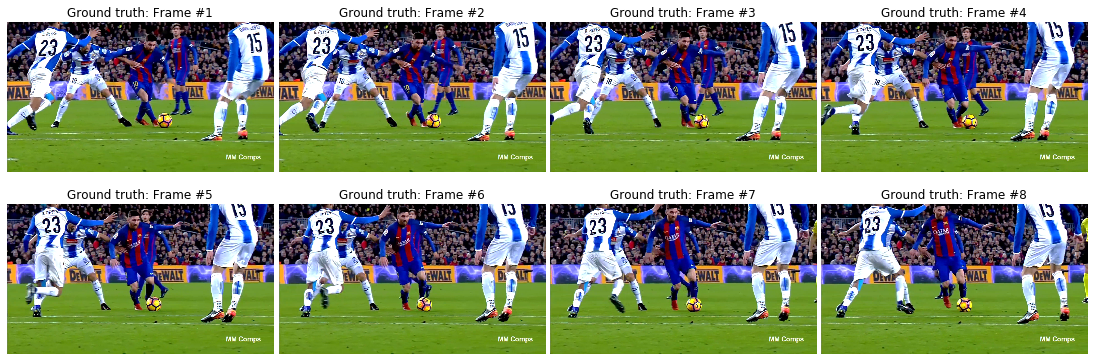

Mean PSNR 38.66 dB.


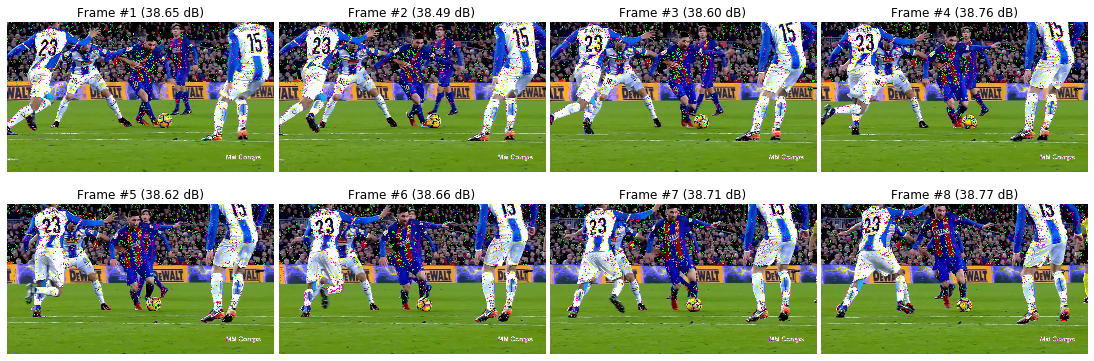

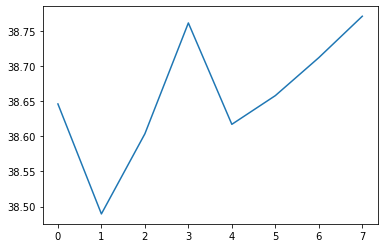

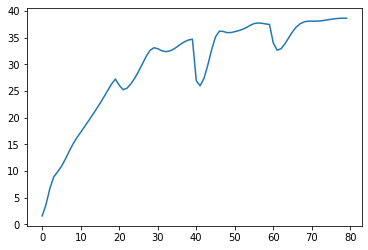

In [8]:
import cv2
# import scipy.io as sio

# file = scipy.io.loadmat(matfile) # for '-v7.2' and below .mat file (MATLAB)
# X = list(file[varname])

# [3.3] result demonstration of GAP-Denoise
vgapdenoise = vgapfastdvdnet_bayer
psnr_gapdenoise = psnrall_fastdvdnet
# vgapdenoise = vgapvnlnet
# psnr_gapdenoise = psnr_gapvnlnet
# vgapdenoise = vadmmvnlnet
# psnr_gapdenoise = psnr_admmvnlnet


fig = plt.figure(figsize=(15, 5))
for nt in range(nmask):
    plt.subplot(2, 4, nt+1)
    # plt.imshow(orig_bayer[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    orig_rgb = cv2.cvtColor(np.uint8(orig_bayer[:,:,nt]*MAXB), cv2.COLOR_BAYER_BG2BGR)
    plt.imshow(orig_rgb)
    plt.axis('off')
    plt.title('Ground truth: Frame #{0:d}'.format(nt+1), fontsize=12)
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

# fig = plt.figure(1)
# fig = plt.figure(figsize=(12, 7))
fig = plt.figure(figsize=(15, 5))
PSNR_rec = np.zeros(nmask)
for nt in range(nmask):
    PSNR_rec[nt] = psnr(vgapdenoise[:,:,nt], orig_bayer[:,:,nt])
    # ax = fig.add_subplot(2,4,nt+1)
    plt.subplot(2, 4, nt+1)
    # plt.imshow(vgapdenoise[:,:,nt], cmap=plt.cm.gray, vmin=0, vmax=1)
    gapdenoise_rgb = cv2.cvtColor(np.uint8(vgapdenoise[:,:,nt]*MAXB), cv2.COLOR_BAYER_BG2BGR)
    plt.imshow(gapdenoise_rgb)
    plt.axis('off')
    plt.title('Frame #{0:d} ({1:2.2f} dB)'.format(nt+1,PSNR_rec[nt]), fontsize=12)
    
print('Mean PSNR {:2.2f} dB.'.format(np.mean(PSNR_rec)))
# plt.title('GAP-{} mean PSNR {:2.2f} dB'.format(denoiser.upper(),np.mean(PSNR_rec)))
plt.subplots_adjust(wspace=0.02, hspace=0.02, bottom=0, top=1, left=0, right=1)
plt.show()   

plt.figure(2)
plt.plot(PSNR_rec)
plt.show()

plt.figure(3)
plt.plot(psnr_gapdenoise)
plt.show()

savedmatdir = resultsdir + '/savedmat/'
if not os.path.exists(savedmatdir):
    os.makedirs(savedmatdir)
# sio.savemat('{}gap{}_{}{:d}.mat'.format(savedmatdir,denoiser.lower(),datname,nmask),
#             {'vgapdenoise':vgapdenoise},{'psnr_gapdenoise':psnr_gapdenoise})
sio.savemat('{}gap{}_{}{:d}_sigma{:d}.mat'.format(savedmatdir,denoiser.lower(),datname,nmask,int(sigma[-1]*MAXB)),
            {'vgaptv_bayer':vgaptv_bayer, 
             'psnr_gaptv':psnr_gaptv,
             'ssim_gaptv':ssim_gaptv,
             'psnrall_tv':psnrall_tv,
             'tgaptv':tgaptv,
             'vgapffdnet_bayer':vgapffdnet_bayer, 
             'psnr_gapffdnet':psnr_gapffdnet,
             'ssim_gapffdnet':ssim_gapffdnet,
             'psnrall_ffdnet':psnrall_ffdnet,
             'tgapffdnet':tgapffdnet,
             'vgapfastdvdnet_bayer':vgapfastdvdnet_bayer, 
             'psnr_gapfastdvdnet':psnr_gapfastdvdnet,
             'ssim_gapfastdvdnet':ssim_gapfastdvdnet,
             'psnrall_fastdvdnet':psnrall_fastdvdnet,
             'tgapfastdvdnet':tgapfastdvdnet})
# sio.savemat(savedmatdir+'gaptv'+'_'+datname+str(ColT)+'.mat',{'vgaptv':vgaptv})
#np.save('Traffic_cacti_T8.npy', f)